In [1]:
# hw link https://relate.cs.illinois.edu/course/cs555-s22/flow-session/835710/2/

In [36]:
import numpy as np
import numpy.linalg as la
from scipy.integrate import simps
import matplotlib.pyplot as plt

In [59]:
# constants
T = 1
X = 1
delta_x = 0.1
delta_t = 0.05




# inputs
def get_gt_and_init(delta_x, delta_t):
    x_arr = np.arange(0, X+delta_x, delta_x)  #11-dim
    t_arr = np.arange(0, T+delta_t, delta_t) #21-dim
    true_solution = np.sin(np.pi *x_arr[:,None]) * np.cos(np.pi * t_arr)#u[x,t] = sin(pix)cos(pit) shape=(11,21)  
    #print(true_solution.shape)
    true_solution[0, :] = 0
    true_solution[-1, :] = 0
    initial_data = true_solution[:, 0] #u(x,0) = sin pi x
    return true_solution, initial_data

spatial_convergence_data = None
#get_gt_and_init(delta_x, delta_t)

In [19]:
def solve(initial_data, delta_x, delta_t):
    num_x = len(np.arange(0, X+delta_x, delta_x))  
    num_t = len(np.arange(0, T+delta_t, delta_t))
    u = np.zeros((num_x, num_t))
    u[:, 0] = initial_data
    
    # calculate firts time step u[x, 1]
    coef = (delta_t / delta_x)**2
    u_zero = u[:,0]  #u[x,0]
    u_neg = np.roll(u[:,0],1) #u[x-1, 0]
    u_pos = np.roll(u[:,0],-1) #u[x+1, 0]  #boundaries don't matter, since they are 0
    u[:, 1] = u_zero + 1/2 * coef* (u_neg - 2*u_zero + coef*u_pos)
    u[0, 1], u[-1, 1] = 0, 0 
    
    
    # calculate remaining time step
    for t in range(1, num_t-1):  #derive u[:, t+1] from u[:, t] and u[:, t-1]
        u_zero = u[:,t]  #u[x,t]
        u_neg = np.roll(u[:,t],1) #u[x-1, t]
        u_pos = np.roll(u[:,t],-1) #u[x+1, t]
        u[:,t+1] = 2*u_zero - u[:,t-1] + coef*(u_pos - 2* u_zero + u_neg)
        u[0, t+1], u[-1, t+1] = 0, 0 
        
    
    return u
    

In [22]:
#solve(initial_data, delta_x, delta_t)

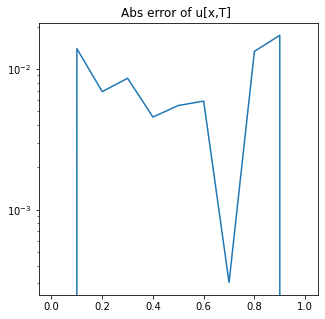

In [28]:
# print squared error of u[x,T]
delta_x = 0.1
delta_t = 0.05
true_solution, initial_data = get_gt_and_init(delta_x, delta_t)
num_solution = solve(initial_data, delta_x, delta_t)

x_arr = np.arange(0, X+delta_x, delta_x)
fig = plt.figure(figsize=(5,5))
plt.title('Abs error of u[x,T] ')
line = plt.plot(x_arr, np.abs(true_solution[:,-1]-num_solution[:,-1]))
plt.yscale("log")
plt.show()


In [71]:
def get_boundary_stencil(delta, degree):
    nodes = np.arange(degree+1) * delta
    V = np.array([nodes**i for i in range(degree+1)]).T
    
    def monomial_deriv(i, x):
        if i == 0:
            return 0*x
        else:
            return i*nodes**(i-1)

    Vprime = np.array([monomial_deriv(i, nodes) for i in range(degree+1)]).T
    fderiv = Vprime @ la.inv(V)
    
    ini_stencil, fin_stencil = fderiv[0,:], fderiv[-1,:]
    return ini_stencil, fin_stencil

def cal_energy(u, delta_x, delta_t):
    x_arr = np.arange(0, X+delta_x, delta_x)
    t_arr = np.arange(0, T+delta_t, delta_t)
    num_x = len(x_arr)  
    num_t = len(t_arr)
    
    #take drivative on t
    u_t = np.zeros(u.shape)
    u_t[:,0] = 0
    for t in range(1, num_t-1):
        u_t[:, t] = (u[:, t+1]- u[:, t-1])/(2* delta_t)
    _, fin_stencil = get_boundary_stencil(delta_t, degree=4)
    u_t[:,-1] = u[:, -len(fin_stencil):].dot(fin_stencil)
    u_t_true = -np.pi * np.sin(np.pi *x_arr[:,None]) * np.sin(np.pi * t_arr)#u_t = -pi sin(pix)sin(pit)
    err = ((u_t[:,:-1] - u_t_true[:,:-1])**2).sum() / (num_x * num_t)
    
    
    
    #take drivative on x
    u_x = np.zeros(u.shape)
    ini_stencil, fin_stencil = get_boundary_stencil(delta_x, degree=4)
    u_x[0,:] = u[ :len(ini_stencil), :].T.dot(ini_stencil)
    u_x[-1,:] = u[-len(fin_stencil):, :].T.dot(fin_stencil)
    for x in range(1, num_x-1):
        u_x[x, :] = (u[x+1,:]- u[x-1,:])/(2* delta_x)
    u_x_true = np.pi * np.cos(np.pi *x_arr[:,None]) * np.cos(np.pi * t_arr)#u_x = pi cos(pix)cos(pit)
    err = ((u_x - u_x_true)**2).sum() / (num_x * num_t)
    print("u_x_err=", err)
    
    eng = simps(y=u_t**2 + u_x**2, x=None, dx=delta_x, axis=0)
    return eng

u_x_err= 0.1568160779448174
u_x_err= 0.06388414873791311
u_x_err= 0.07334869926707588
u_x_err= 0.0907040909130787
u_x_err= 0.08043722072445783
u_x_err= 0.19437399933633925
u_x_err= 0.3190923029082333
u_x_err= 0.7778888653040413
u_x_err= 1.8963000324089405
u_x_err= 4.599752311381318
u_x_err= 11.181299013501514
u_x_err= 26.92626671477971
u_x_err= 64.22897486498401
u_x_err= 150.5613320388155
u_x_err= 345.2111331608528
u_x_err= 761.2824100697479
u_x_err= 1568.14103249586
u_x_err= 2842.534819586794
u_x_err= 3897.191737090278
u_x_err= 2170.2374137770557


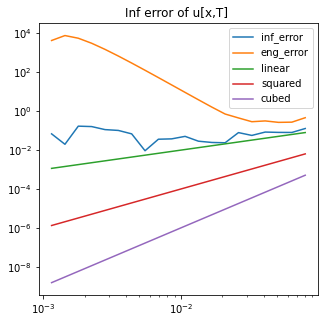

In [73]:
spatial_convergence_data = list()
delta_t = 0.001
delta_x = 0.1
decay = 0.8

for i in range(20):
    delta_x *= decay
    true_solution, initial_data = get_gt_and_init(delta_x, delta_t)
    spatial_convergence_data.append((delta_x, initial_data, true_solution))


delta_x_list = []
inf_error_list = []
error_eng_list = []

for delta_x, initial_data, true_solution in spatial_convergence_data:
    delta_x_list.append(delta_x)
    num_solution = solve(initial_data, delta_x, delta_t)
    inf_error = np.abs(true_solution[:,-1]-num_solution[:,-1]).max()
    inf_error_list.append(inf_error)
    eng = cal_energy(num_solution, delta_x, delta_t)
    error_eng = np.max(eng) - np.min(eng)
    error_eng_list.append(error_eng)

delta_x_arr = np.array(delta_x_list)
inf_error_arr = np.array(inf_error_list)
error_eng_arr = np.array(error_eng_list)

fig = plt.figure(figsize=(5,5))
plt.title('Inf error of u[x,T] ')
plt.plot(delta_x_arr, inf_error_arr, label="inf_error")
plt.plot(delta_x_arr, error_eng_arr, label="eng_error")
plt.plot(delta_x_arr, delta_x_arr, label="linear")
plt.plot(delta_x_arr, delta_x_arr**2, label="squared")
plt.plot(delta_x_arr, delta_x_arr**3, label="cubed")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()


In [74]:
a = np.arange(10)
a[-6:]

array([4, 5, 6, 7, 8, 9])

In [43]:
b = np.arange(11)
a *b

ValueError: operands could not be broadcast together with shapes (10,) (11,) 